# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.


### Important Note
>Delete the **data/** folder and the downloaded tar file, before you submit your code. The current workspace cannot save the files beyond 1GB of space in total. 


### Import the Packages

In [351]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 1: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

>Note: If you experience "Kernel died" issue while running the codeblock below, then load less number of rows from the .csv files.

In [201]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

/var/folders/74/k7spccmj5r378byq_vqt012h0000gn/T/ipykernel_1480/4183925281.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
/var/folders/74/k7spccmj5r378byq_vqt012h0000gn/T/ipykernel_1480/4183925281.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')


### 1.1 Dealing with mixed types

In [202]:
# display unique values in the columns 18 and 19 in the azdias dataset
print('AZDIAS\nUnique values in column 18:', azdias.iloc[:, 18].unique())
print('Unique values in column 19:', azdias.iloc[:, 19].unique(), '\n')

# display unique values in the columns 18 and 19 in the customers dataset
print('CUSTOMERS\nUnique values in column 18:', customers.iloc[:, 18].unique())
print('Unique values in column 19:', customers.iloc[:, 19].unique())

AZDIAS
Unique values in column 18: [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
Unique values in column 19: [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX'] 

CUSTOMERS
Unique values in column 18: [1.0 nan 5.0 4.0 7.0 3.0 9.0 2.0 6.0 8.0 '6' '3' '8' '9' '2' '4' '1' '7'
 '5' 'X']
Unique values in column 19: [13.0 nan 34.0 24.0 41.0 23.0 15.0 55.0 14.0 22.0 43.0 51.0 33.0 25.0 44.0
 54.0 32.0 12.0 35.0 31.0 45.0 52.0 '45' '25' '55' '51' '14' '54' '43'
 '22' '15' '24' '35' '23' '12' '44' '41' '52' '31' '13' '34' '32' '33'
 'XX']


In [203]:
# show the frequency of each unique value in column 18 and 19 in the azdias dataset
print('AZDIAS\nFrequency in column 18', azdias.iloc[:, 18].value_counts(), '\n')
print('Frequency in column 19', azdias.iloc[:, 19].value_counts(), '\n')

# show the frequency of each unique value in column 18 and 19 in the customers dataset
print('CUSTOMERS\nFrequency in column 18', customers.iloc[:, 18].value_counts(), '\n')
print('Frequency in column 19', customers.iloc[:, 19].value_counts())

AZDIAS
Frequency in column 18 CAMEO_DEUG_2015
8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: count, dtype: int64 

Frequency in column 19 CAMEO_INTL_2015
51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: count, dtype: int64 

CUSTOMERS


In [204]:
# columns to clean
columns_to_clean = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
datasets = {'azdias': azdias, 'customers': customers}

# loop through each dataset and column to clean numeric strings and set 'x' / 'XX'to NaN
for name, df in datasets.items():
    for col in columns_to_clean:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
# check
print('AZDIAS\nUnique values in column 18:', azdias.iloc[:, 18].unique())
print('Unique values in column 19:', azdias.iloc[:, 19].unique(), '\n')

# check
print('CUSTOMERS\nUnique values in column 18:', customers.iloc[:, 18].unique())
print('Unique values in column 19:', customers.iloc[:, 19].unique())

AZDIAS
Unique values in column 18: [nan  8.  4.  2.  6.  1.  9.  5.  7.  3.]
Unique values in column 19: [nan 51. 24. 12. 43. 54. 22. 14. 13. 15. 33. 41. 34. 55. 25. 23. 31. 52.
 35. 45. 44. 32.] 

CUSTOMERS
Unique values in column 18: [ 1. nan  5.  4.  7.  3.  9.  2.  6.  8.]
Unique values in column 19: [13. nan 34. 24. 41. 23. 15. 55. 14. 22. 43. 51. 33. 25. 44. 54. 32. 12.
 35. 31. 45. 52.]


In this step, I focused on cleanung the columns 'CAMEO_DEUG_2015' and 'CAMEO_INTL_2015' in both azdias and customers datasets. These columns contained a mix of numeric values, numeric strings and non-numeric placeholders ('X' and 'XX').<br>
First, I converted all numeric strings to float values in order to unify the data type. Then I replaced 'X' and 'XX' with NaN since they represent a small number of values and likely don't carry significant information.<br>

### 1.2 Check the data structure

In [206]:
# check column amount and data types in both datasets
print(azdias.info(), '\n')
print(customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(269), int64(93), object(4)
memory usage: 2.4+ GB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(269), int64(94), object(6)
memory usage: 539.5+ MB
None


To better understand the data structure, I conducted an analysis to verify that all features (columns) in the datasets are represented in the provided informational spreadsheets. This step was essential to ensure alignment between the data and documentation, allowing for accurate interpretation of each attribute's meaning and value ranges.<br>

In [207]:
# load excel files containing attribute information
attribute_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', usecols=[1], skiprows=1, names=['Attribute'])
attributes_levels = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', usecols=[2], skiprows=1, names=['Attribute'])

# drop empty rows in each list of attributes
attributes_values = attribute_values.dropna().reset_index(drop=True)
attributes_levels = attributes_levels.dropna().reset_index(drop=True)

# find the attribute present in 'DIAS Attributes - Values 2017.xlsx' but not in 'DIAS Information Levels - Attributes 2017.xlsx'
extra_attribute = set(attribute_values['Attribute']).difference(set(attributes_levels['Attribute']))
print(extra_attribute, '\n')

# combine unique attributes from both lists
unique_attributes = set(attributes_values['Attribute']).union(set(attributes_levels['Attribute']))

# extract column names in each dataset
azdias_columns = set(azdias.columns)
customers_columns = set(customers.columns)

# identify extra columns in each dataset
extra_azdias_columns = sorted(azdias_columns - unique_attributes)
extra_customers_columns = sorted(customers_columns - unique_attributes)

# display the extra columns in each dataset
print(extra_azdias_columns)
print(extra_customers_columns)

{'D19_GESAMT_ANZ_12', 'D19_BANKEN_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_VERSI_ANZ_12', 'D19_VERSAND_ANZ_24', nan, 'D19_BANKEN_ANZ_24', 'D19_TELKO_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_12', 'D19_LOTTO_RZ', 'BIP_FLAG', 'KBA13_CCM_3000', 'D19_VERSI_ANZ_24', 'KBA13_CCM_3001'} 

['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_INTL_2015', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REI

In [208]:
# check if a column is in azdias dataset
azdias_has_column = 'CAMEO_INTL_2015' in azdias.columns
print(azdias_has_column)

# check if a column is in attributes_values dataframe
is_in_attributes_values = 'CAMEO_DEUINTL_2015' in attributes_values['Attribute'].values
print(is_in_attributes_values)

True
True


The two spreadsheets provided were titled DIAS Attributes - Values 2017.xlsx' and 'DIAS Information Levels - Attributes 2017.xlsx'. To confirm completeness and consistency, I compared the features listed in each spreasheet. This comparison revealed a few minor discrepancies. Specifically, the majority of differences were due to the variations in abbreviations rather than actual missing attributes. For example, 'D19_VERSAND_ANZ_12' and 'D19_VERSAND_ANZ_24' were listed in the 'levels' spreadsheet as 'D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24', highlighting only a formatting difference.<br>
After identifying each inconsistency, I determined that only two attributes, 'BIP_Flag' and 'D19_Lotto' were entirely unique to the 'values' spreadsheet. However, I see it uncritically.<br>

In order to understand why the azdias and customers datasets have 366 (or 369 respectively) features while the information spreadsheets list only 314 (or 313), I have analyzed the discrepancy and discovered two key points:<br>
1. Some columns in the datasets, such as 'AKT_DAT_KL' or 'ALTERSKATEGORIE_FEIN', are extra columns that are not covered in the spreadsheets.<br>
2. Other columns appear "extra" but are, in fact, covered in the spreedsheets under slightly different names, like 'CAMEO_INTL_2015' in azdias vs. 'CAMEO_DEUINTL_2015' in the documentation.<br>
To decide, which columns to keep, as columns without documentation lack interpretability, I manually compared the extra columns against similar names int he spreadsheets. Through the process, I identified a final list of columns without documentation and decided to drop them, ensuring a more robust and interpretable dataset for analysis.<br>

Columns to be droped: 'AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE' 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES' 'D19_VERSI_ONLINE_QUOTE_12', 'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992', 'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_GBZ', 'KBA13_CCM_1401_2500', 'KBA13_HHZ', 'KBA13_KMH_210', 'KOMBIALTER', 'KONSUMZELLE', 'LNR', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'SOHO_KZ', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'.<br>

As a result, I've achieved a transparent view of the data structure and can proceed with further steps.

In [262]:
# list of columns to drop
columns_to_drop1 = [
    'AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', \
    'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', \
    'D19_SOZIALES', 'D19_VERSI_ONLINE_QUOTE_12', 'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992', 'FIRMENDICHTE', 'GEMEINDETYP', \
    'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_GBZ', 'KBA13_CCM_1401_2500', 'KBA13_HHZ', \
    'KBA13_KMH_210', 'KOMBIALTER', 'KONSUMZELLE', 'LNR', 'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', \
    'SOHO_KZ', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM', 'VHA', 'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', \
    'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'
]

# drop columns from azdias and customers
azdias = azdias.drop(columns=columns_to_drop1, errors='ignore')
customers = customers.drop(columns=columns_to_drop1, errors='ignore')

# Verify that the columns are dropped
print(azdias.columns, '\n')
print(customers.columns)

Index(['AGER_TYP', 'ALTER_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'ARBEIT', 'BALLRAUM', 'CAMEO_DEU_2015',
       'CAMEO_DEUG_2015',
       ...
       'SEMIO_VERT', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=313) 

Index(['AGER_TYP', 'ALTER_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'ARBEIT', 'BALLRAUM', 'CAMEO_DEU_2015',
       'CAMEO_DEUG_2015',
       ...
       'SEMIO_VERT', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=313)


### 1.3 Assess Missing Data
#### 1.3.1 Convert Missing Values Codes to NaN

I will begin by checking the datasets 'azdias' and 'customers' for naturally missing values represented by NaN.

In [210]:
# calculate the amount of missing values in each column for azdias
missing_azdias_count = azdias.isnull().sum()
missing_azdias_count = missing_azdias_count[missing_azdias_count > 0].sort_values(ascending=False)
print('Missing values in azdias dataset', missing_azdias_count)

# calculate the amount of missing values in each column for customers
missing_customers_count = customers.isnull().sum()
missing_customers_count = missing_customers_count[missing_customers_count > 0].sort_values(ascending=False)
print('\nMissing calues in customers dataset', missing_customers_count)

Missing values in azdias dataset KK_KUNDENTYP                   584612
D19_KONSUMTYP                  257113
D19_VERSAND_ONLINE_QUOTE_12    257113
D19_BANKEN_ONLINE_QUOTE_12     257113
D19_GESAMT_ONLINE_QUOTE_12     257113
                                ...  
RETOURTYP_BK_S                   4854
ONLINE_AFFINITAET                4854
LP_LEBENSPHASE_FEIN              4854
LP_LEBENSPHASE_GROB              4854
LP_STATUS_FEIN                   4854
Length: 222, dtype: int64

Missing calues in customers dataset KK_KUNDENTYP           111937
KBA05_KRSVAN            55980
KBA05_MOD8              55980
KBA05_MOD3              55980
KBA05_MOD2              55980
                        ...  
LP_FAMILIE_GROB          3213
LP_LEBENSPHASE_FEIN      3213
LP_STATUS_GROB           3213
LP_LEBENSPHASE_GROB      3213
HH_EINKOMMEN_SCORE       2968
Length: 222, dtype: int64


In [211]:
# check total missing values before converting codes for missing values to NaN
missing_before_azdias = azdias.isna().sum().sum()
missing_before_customers = customers.isna().sum().sum()
print(missing_before_azdias, ' ', missing_before_customers)

25110214   11170915


Many attributes use specific codes (like -1 or 0) to represent 'missing' or 'unknown' values rather than using NaN. The spreadsheet 'DIAS Attributes - Values 2017.xlsx' contains detailed attribute descriptions and possible value, including those used to signify missing data.

In [212]:
# load the spreadsheet where attrubutes and possible values are listed
attributes_df = pd.read_excel('DIAS Attributes - Values 2017.xlsx', usecols=[1, 3, 4], skiprows=1, names=['Attribute', 'Value', 'Meaning'])

# forward fill the 'attribute' column (as an attribute is only mentioned once with subsequent rows having blank 'attribute' values until a new attribute starts)
attributes_df['Attribute'] = attributes_df['Attribute'].ffill()

# define keywords for missing or unknown data based on the description in the 'meaning' column
missing_keywords = ['unknown', 'no classification possible', 'uniformly distributed', 'unknown / no main age detectable', 'classification not possible']

# filter rows where the value descriptions contain any of the missing keywords
missing_values_df = attributes_df[attributes_df['Meaning'].str.contains('|'.join(missing_keywords), case=False, na=False)]

# group the missing codes by attribute and aggregate them into a list
missing_codes_grouped = (
    missing_values_df
    .groupby('Attribute')['Value']
    .apply(lambda x: list(x))
    .reset_index()
)

# rename columns to match the desired output
missing_codes_grouped.columns = ['attribute', 'missing_or_unknown']

# display the resulting dataframe
print(missing_codes_grouped)

                attribute missing_or_unknown
0                AGER_TYP            [-1, 0]
1    ALTERSKATEGORIE_GROB         [-1, 0, 9]
2                ALTER_HH                [0]
3               ANREDE_KZ            [-1, 0]
4                BALLRAUM               [-1]
..                    ...                ...
228    WACHSTUMSGEBIET_NB            [-1, 0]
229        WOHNDAUER_2008            [-1, 0]
230              WOHNLAGE               [-1]
231        W_KEIT_KIND_HH            [-1, 0]
232              ZABEOTYP            [-1, 9]

[233 rows x 2 columns]


To capture only the relevant rows I filtered for descriptions in the spreadsheet that indicated missing data, like "unknown" or "no classification possible". This produced a table of rows with attributes and their associated missing codes. I aggregated this data into a table, listing each attribute alongside its specific codes for missing data. This table will serve as a reference for converting all coded missing values to NaN.<br>
I checked that the column 'missing_or_unknown' only contains list of codes and not single string. So I can procees with replacing coded missing values with NaN.<br>

As identified before some attribute names in the 'azdias' and 'customers' datasets differ slightly from those in the 'DIAS Attributes - Values 2017.xlsx' spreadsheet. This would prevent the missing value codes frim being replaced with NaN. To address this, I will create a dictionary attribute_name_mapping, to map spreadsheet attribute names to the corresponding names in the datasets.

In [213]:
# mapping for attributes with different names
attribute_name_mapping = {
    'CAMEO_DEUG_2015': 'CAMEO_INTL_2015',
    'D19_BANKEN_DIREKT_RZ': 'D19_BANKEN_DIREKT',
    'D19_BANKEN_GROSS_RZ': 'D19_BANKEN_GROSS',
    'D19_BANKEN_LOKAL_RZ': 'D19_BANKEN_LOKAL',
    'D19_BANKEN_REST_RZ': 'D19_BANKEN_REST',
    'D19_BEKLEIDUNG_GEH_RZ': 'D19_BEKLEIDUNG_GEH',
    'D19_BEKLEIDUNG_REST_RZ': 'D19_BEKLEIDUNG_REST',
    'D19_BILDUNG_RZ': 'D19_BILDUNG',
    'D19_BIO_OEKO_RZ': 'D19_BIO_OEKO',
    'D19_BUCH_RZ': 'D19_BUCH_CD',
    'D19_DIGIT_SERV_RZ': 'D19_DIGIT_SERV',
    'D19_DROGERIEARTIKEL_RZ': 'D19_DROGERIEARTIKEL',
    'D19_ENERGIE_RZ': 'D19_ENERGIE',
    'D19_FREIZEIT_RZ': 'D19_FREIZEIT',
    'D19_GARTEN_RZ': 'D19_GARTEN',
    'D19_HANDWERK_RZ': 'D19_HANDWERK',
    'D19_HAUS_DEKO_RZ': 'D19_HAUS_DEKO',
    'D19_KINDERARTIKEL_RZ': 'D19_KINDERARTIKEL',
    'D19_KK_KUNDENTYP': 'KK_KUNDENTYP',
    'D19_KONSUMTYP': 'D19_KONSUMTYP_MAX',
    'D19_KOSMETIK_RZ': 'D19_KOSMETIK',
    'D19_LEBENSMITTEL_RZ': 'D19_LEBENSMITTEL',
    'D19_NAHRUNGSERGAENZUNG_RZ': 'D19_NAHRUNGSERGAENZUNG',
    'D19_RATGEBER_RZ': 'D19_RATGEBER',
    'D19_REISEN_RZ': 'D19_REISEN',
    'D19_SAMMELARTIKEL_RZ': 'D19_SAMMELARTIKEL',
    'D19_SCHUHE_RZ': 'D19_SCHUHE',
    'D19_SONSTIGE_RZ': 'D19_SONSTIGE',
    'D19_TECHNIK_RZ': 'D19_TECHNIK',
    'D19_TELKO_MOBILE_RZ': 'D19_TELKO_MOBILE',
    'D19_TELKO_ONLINE_DATUM': 'D19_TELKO_ONLINE_QUOTE_12',
    'D19_TELKO_REST_RZ': 'D19_TELKO_REST',
    'D19_TIERARTIKEL_RZ': 'D19_TIERARTIKEL',
    'D19_VERSAND_REST_RZ': 'D19_VERSAND_REST',
    'D19_VERSICHERUNGEN_RZ': 'D19_VERSICHERUNGEN',
    'D19_VOLLSORTIMENT_RZ': 'D19_VOLLSORTIMENT',
    'D19_WEIN_FEINKOST_RZ': 'D19_WEIN_FEINKOST'
}

for _, row in missing_codes_grouped.iterrows():
    # original attribute name from the spreadsheet
    attribute = row['attribute']
    # get the corresponding name in the datasets if it differs
    dataset_attribute = attribute_name_mapping.get(attribute, attribute)
    # get the list of missing codes for the attribute
    missing_codes = row['missing_or_unknown']

    # check if the attribute exists in the dataset
    if dataset_attribute in azdias.columns:
        azdias[dataset_attribute] = azdias[dataset_attribute].replace(missing_codes, np.nan)
    if dataset_attribute in customers.columns:
        customers[dataset_attribute] = customers[dataset_attribute].replace(missing_codes, np.nan)

I used the mapping in the code to replace the missing values with Nan, ensuring each attribute was correctly referenced in the datasets. Iterating through each attribute I replaced the missing values with NaN in both datasets.

In [214]:
# check total missing values after converting codes for missing data to NaN
missing_after_azdias = azdias.isna().sum().sum()
missing_after_customers = customers.isna().sum().sum()
print('Increase in NaN in azdias: ', missing_after_azdias-missing_before_azdias)
print('Increase in NaN in customers: ', missing_after_customers-missing_before_customers)

Increase in NaN in azdias:  1259080
Increase in NaN in customers:  266099


 Finally, I verified that the replacement was successful by checking the increase in NaN values and confirming the absence of the original missing codes in sample columns.<br>

 #### 1.3.2 Assess Missing Data in Each Column

In [ ]:
# perform an assessment of how much missing data there is in each column of the dataset
missing_data_azdias = azdias.isnull().mean()*100
print('\nMissing Data in Azdias dataset:')
print(missing_data_azdias.sort_values(ascending=False))

missing_data_customers = customers.isnull().mean()*100
print('\nMissing Data in Customers dataset:')
print(missing_data_customers.sort_values(ascending=False))


Missing Data in Azdias dataset:
AGER_TYP                       76.955435
KK_KUNDENTYP                   65.596749
ALTER_HH                       34.813699
D19_VERSAND_ONLINE_QUOTE_12    28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
                                 ...    
D19_KINDERARTIKEL               0.000000
D19_HAUS_DEKO                   0.000000
D19_HANDWERK                    0.000000
D19_GESAMT_ONLINE_DATUM         0.000000
D19_VERSI_ONLINE_DATUM          0.000000
Length: 313, dtype: float64

Missing Data in Customers dataset:
KK_KUNDENTYP               58.406382
AGER_TYP                   50.475863
ALTER_HH                   35.870745
KBA05_KRSHERST1            29.209192
KBA05_HERST1               29.209192
                             ...    
D19_KINDERARTIKEL           0.000000
D19_HAUS_DEKO               0.000000
D19_HANDWERK                0.000000
D19_GESAMT_ONLINE_DATUM     0.000000
D19_VERSAND_REST            0.000000
Length: 313, dtype: float64


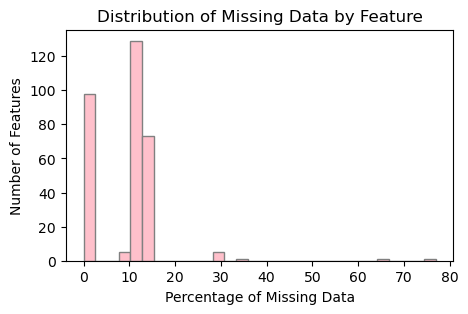

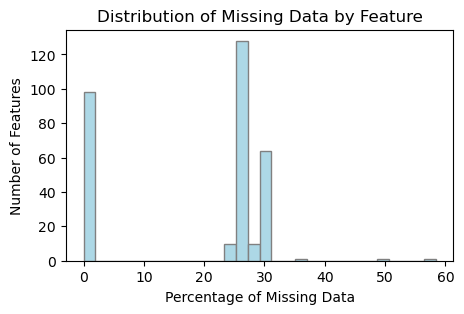

In [216]:
plt.figure(figsize=(5,3))
plt.hist(missing_data_azdias, bins=30, color='pink', edgecolor='grey')
plt.title('Distribution of Missing Data by Feature')
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Number of Features')
plt.show()

plt.figure(figsize=(5,3))
plt.hist(missing_data_customers, bins=30, color='lightblue', edgecolor='grey')
plt.title('Distribution of Missing Data by Feature')
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Number of Features')
plt.show()

In [ ]:
# investigate patterns in the amount of missing data in each column
# columns with more than 20% missing data
high_missing_threshold = 20

high_missing_columns_azdias = missing_data_azdias[missing_data_azdias > high_missing_threshold].sort_values(ascending=False)
print('Columns with more than 20% missing data (Azdias):\n', high_missing_columns_azdias)

high_missing_columns_customers = missing_data_customers[missing_data_customers > high_missing_threshold].sort_values(ascending=False)
print('\nColumns with more than 20% missing data (Customers):\n', high_missing_columns_customers)

Columns with more than 20% missing data (Azdias):
 AGER_TYP                       76.955435
KK_KUNDENTYP                   65.596749
ALTER_HH                       34.813699
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
dtype: float64

Columns with more than 20% missing data (Customers):
 KK_KUNDENTYP      58.406382
AGER_TYP          50.475863
ALTER_HH          35.870745
KBA05_KW3         29.209192
KBA05_MOD2        29.209192
                    ...    
KONSUMNAEHE       24.341515
ANZ_PERSONEN      24.312817
TITEL_KZ          24.312817
WOHNDAUER_2008    24.312817
ANZ_TITEL         24.312817
Length: 215, dtype: float64


In [218]:
num_high_missing_azdias = len(high_missing_columns_azdias)
num_high_missing_customers = len(high_missing_columns_customers)
print(f'Number of columns with more than 20% of missing data in Azdias dataset: {num_high_missing_azdias}')
print(f'Number of columns with more than 20% of missing data in Customers dataset: {num_high_missing_customers}')

high_missing_columns_azdias_set = set(high_missing_columns_azdias.index)
high_missing_columns_customers_set = set(high_missing_columns_customers.index)

missing_in_both = high_missing_columns_azdias_set.issubset(high_missing_columns_customers_set)
print(f'\nAll columns with more than 20% missing in Azdias are also missing in Customers: {missing_in_both}')

if not missing_in_both:
    missing_columns_diff = high_missing_columns_azdias_set - high_missing_columns_customers_set
    print(f'\nColumns with more than 20% missing in Azdias but not in Customers : {missing_columns_diff}')


Number of columns with more than 20% of missing data in Azdias dataset: 8
Number of columns with more than 20% of missing data in Customers dataset: 215

All columns with more than 20% missing in Azdias are also missing in Customers: True


In [ ]:
# remove the outlier columns from the dataset
columns_to_drop2 = high_missing_columns_azdias.index

azdias_cleaned = azdias.drop(columns=columns_to_drop2)
customers_cleaned = customers.drop(columns=columns_to_drop2)

# check the new shape of the Dataframe
print('Shape of the cleaned Azdias Dataframe: ', azdias_cleaned.shape)
print('\nShape of the cleaned Customers Dataframe: ', customers_cleaned.shape)

Shape of the cleaned Azdias Dataframe:  (891221, 305)

Shape of the cleaned Customers Dataframe:  (191652, 305)


There are 8 columns with more than 20% missing data in the Azdias dataset.<br>
There are 215 columns with more than 20% missing data in the Customers dataset.<br>
All 8 columns with more than 20% missing data in the Azdias Dataset are also present in the Customers dataset with more than 20% missing data.<br>

I decided to remove 8 columns with more than 20% missing data from both dataset. <br>
The remaining 207 columns with more than 20% missing data in the Customers dataset will be retained in both dataset.<br>
Removing the same columns from both datasets insures consistency in the further analysis. By retaining the other columns with more than 20% missing data in the Customers dataset I ensure that customer data can be compared effectively to the general population.<br>

#### 1.3.3 Assess Missing Data in Each Row


Next, I'll assess the rows of the dataset by checking the amount of missing data in each.

In [ ]:
# how much data is missing in each row of the dataset?
missing_data_row = azdias_cleaned.isnull().mean(axis=1)*100
print(missing_data_row.head())

0    67.868852
1     0.000000
2     0.000000
3     0.327869
4     0.000000
dtype: float64


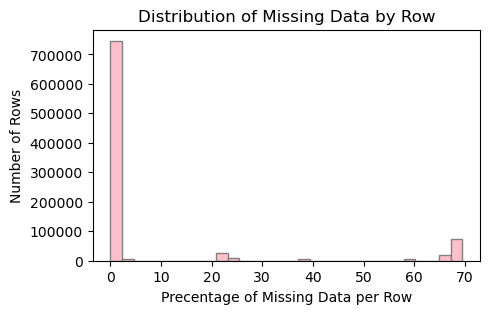

In [221]:
plt.figure(figsize=(5,3))
plt.hist(missing_data_row, bins=30, color='pink', edgecolor='grey')
plt.title('Distribution of Missing Data by Row')
plt.xlabel('Precentage of Missing Data per Row')
plt.ylabel('Number of Rows')
plt.show()

I will divide data into two subsets: one with rows above a certain threshold of missing values and one below it.

In [ ]:
# write code to divide the data into two subsets based on the number of missing values in each row
missing_threshold_row = 10
# subset 1: Rows with missing data above the threshold
subset_high_missing = azdias_cleaned[missing_data_row > missing_threshold_row]
print(f"Number of rows with more that {missing_threshold_row}% missing data: {subset_high_missing.shape[0]}")
# subset 2: Rows with missing data below the threshold
subset_low_missing = azdias_cleaned[missing_data_row <= missing_threshold_row]
print(f"Number of rows with {missing_threshold_row}% or less missing data: {subset_low_missing.shape[0]}")

Number of rows with more that 10% missing data: 139890
Number of rows with 10% or less missing data: 751331


To understand the two subsets I will compare the distribution of values in at least five columns.

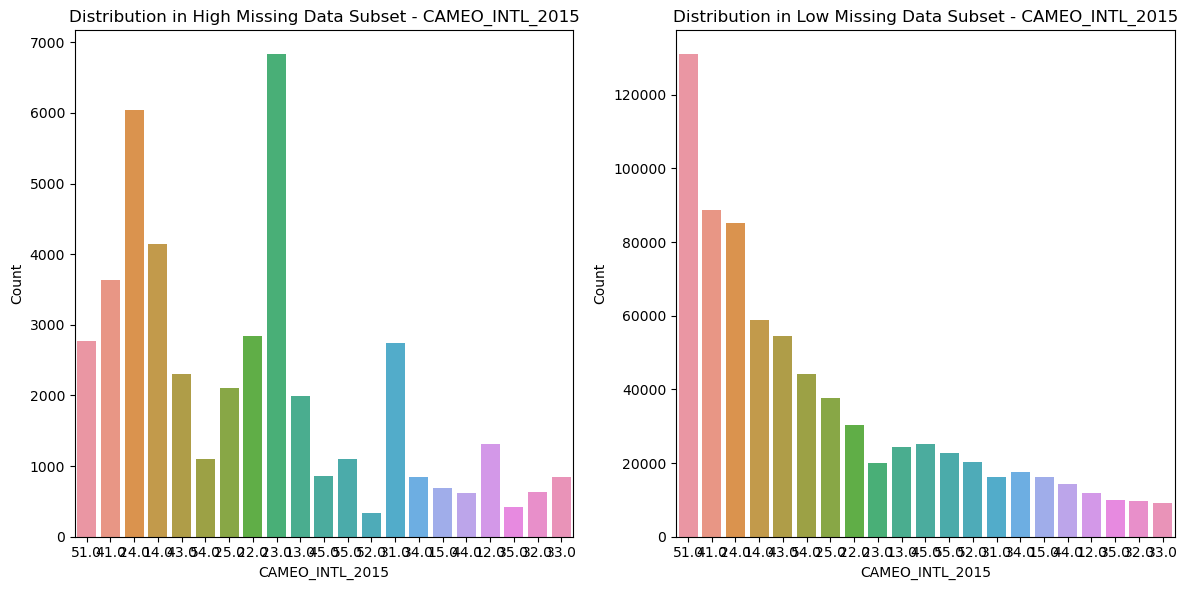

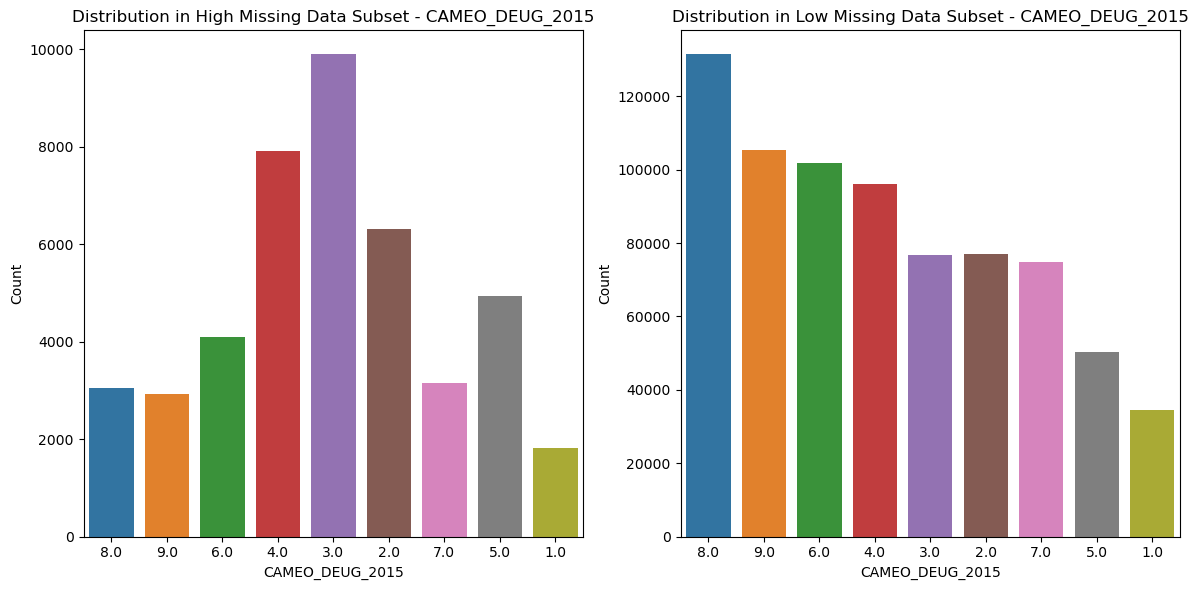

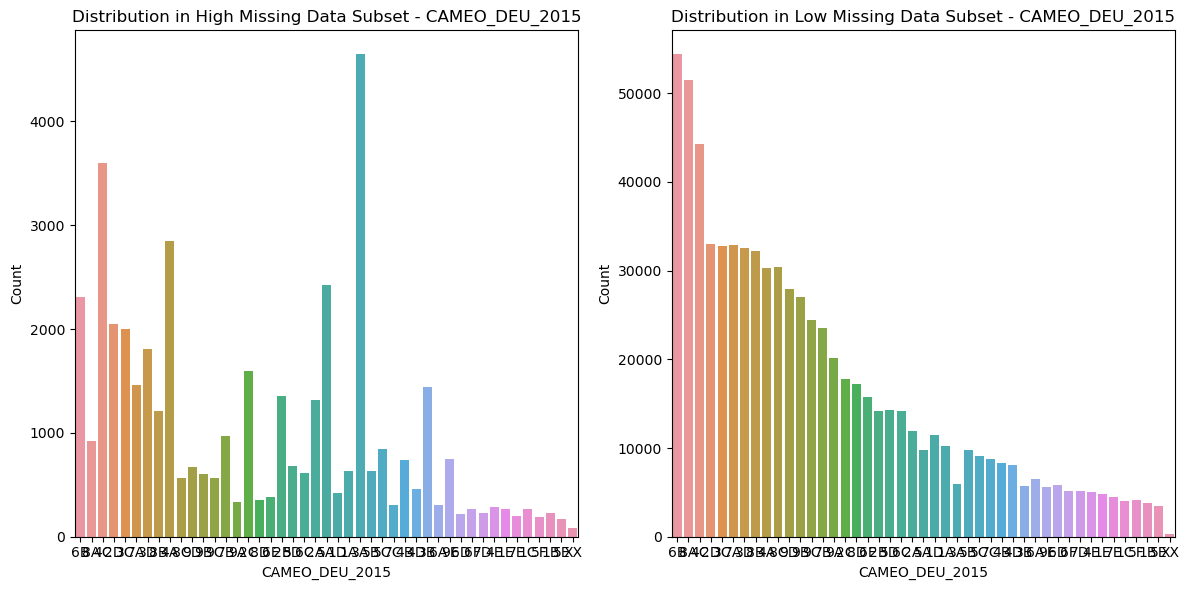

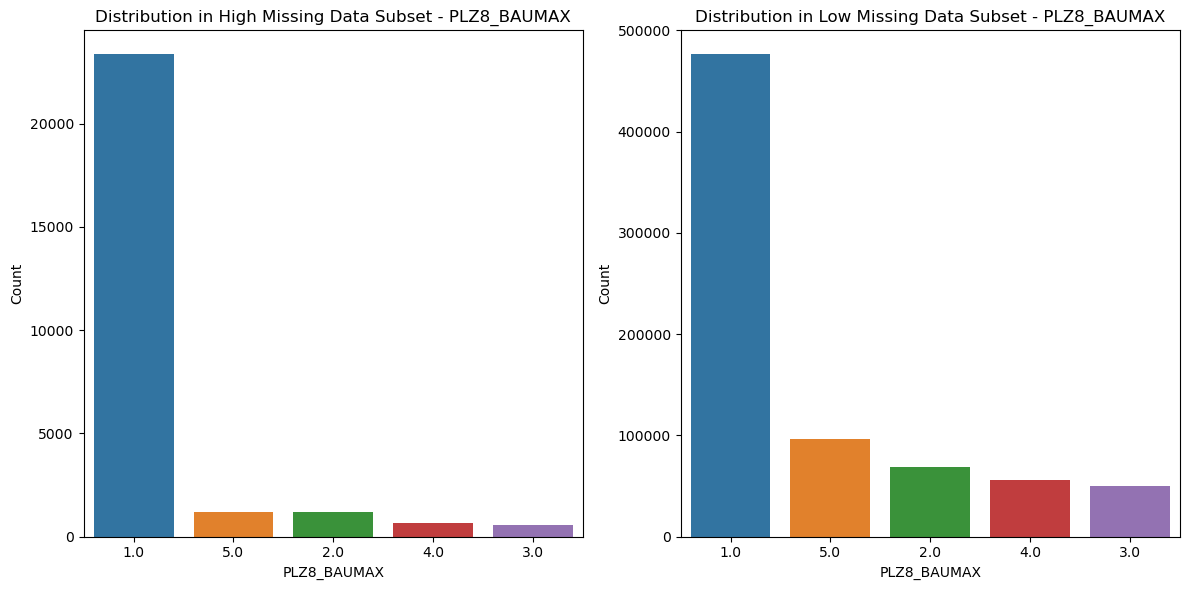

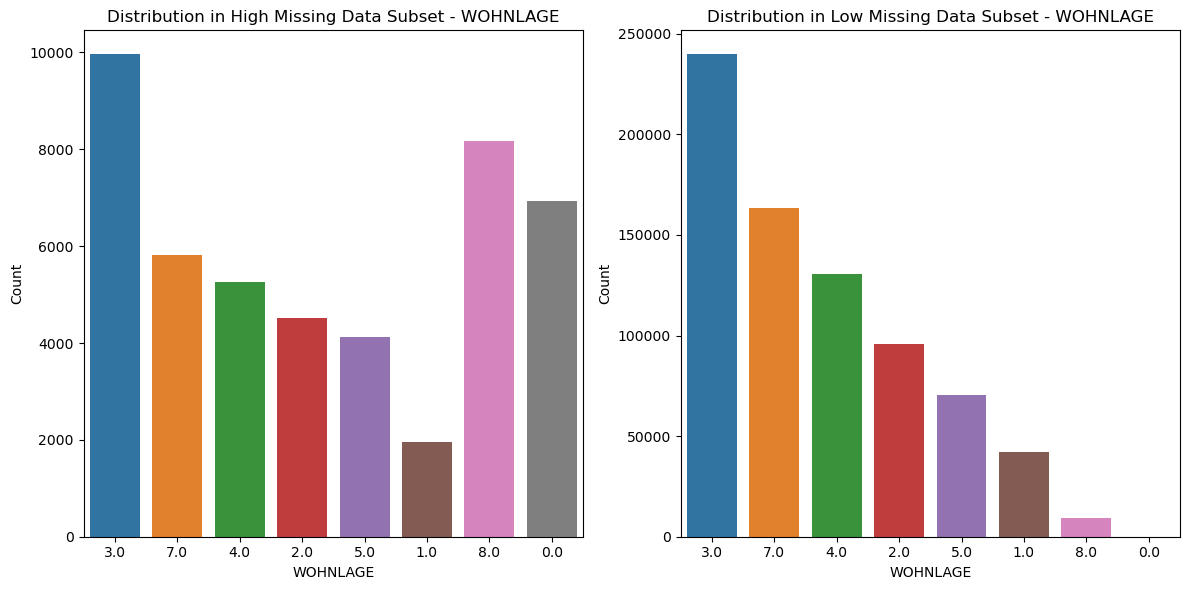

In [ ]:
# compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.
def compare_distributions(column, subset1, subset2):
    # sort column categories in descending order in order to simplify the visual
    # inspection of the distribution between the two subsets.
    combined = pd.concat([subset1[column], subset2[column]])
    order = combined.value_counts().index
    
    plt.figure(figsize=(12,6))
    
    # subplot for subset with high missing values
    plt.subplot(1,2,1)
    sns.countplot(x=column, data=subset1, order=order)
    plt.title(f'Distribution in High Missing Data Subset - {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    
    # subplot for subset with low missing values
    plt.subplot(1,2,2)
    sns.countplot(x=column, data = subset2, order=order)
    plt.title(f'Distribution in Low Missing Data Subset - {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
# select columns to compare
# as the goal of the project is to identify the customer segments the columns
# should provide a mix of demographoc, geographic and socio-economic data which I suppose the selected
# columns represent the best
columns_to_compare = ['CAMEO_INTL_2015', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'PLZ8_BAUMAX', 'WOHNLAGE']
    
# compare distributions for the selected columns
for column in columns_to_compare:
    compare_distributions(column, subset_high_missing, subset_low_missing)

Most of the rows in the dataset have less than 10% missing values. However, there is still a number of rows with more than 10% missing data.<br>

I decided to compare the distribution of values in the columns CAMEO_INTL_2015, CAMEO_DEUG_2015, CAMEO_DEU_2015, PLZ8_BAUMAX and WOHNLAGE, as I suppose those features are particularly important for identifying customer segments.<br>

While some values are consistently dominant across both datasets, there are particular differences in the distribution of other values.<br>
The reason for this could be that the rows with high missing values represent different demographic segments or behaviours rather than the rows with low missing values. Thus the rows with high missing values contain unique and important information and simply removing these rows could potentially bias the analysis.

#### 1.4 Select and Re-Encode Features 

Preparing a dataset for analysis goes beyond handling missing data. Since unsupervised learning requires numeric encoding, some features will need adjustments.<br>
I will perform further steps:
- keep numeric, interval and ordinal features as they are
- handle categorical and mixed-type features with additional investigation deciding whether to keep, drop or re-encode each.

In [224]:
# check data types and count of each type in azdias dataset
print(azdias_cleaned.dtypes.value_counts())
print('\n', customers_cleaned.dtypes.value_counts())

float64    217
int64       86
object       2
Name: count, dtype: int64

 float64    217
int64       86
object       2
Name: count, dtype: int64


In [225]:
# display names of the object-type columns in azdias and customers
object_columns_azdias = azdias_cleaned.select_dtypes(include='object').columns
object_columns_customers = customers_cleaned.select_dtypes(include='object').columns

print(object_columns_azdias)
print(object_columns_customers)

# view unique values in each object column to determine their content
for col in object_columns_azdias:
    print(f'\nUnique values in {col} (azdias):', azdias_cleaned[col].unique())

for col in object_columns_customers:
    print(f'\nUnique values in {col} (customers):', customers_cleaned[col].unique())


Index(['CAMEO_DEU_2015', 'OST_WEST_KZ'], dtype='object')
Index(['CAMEO_DEU_2015', 'OST_WEST_KZ'], dtype='object')

Unique values in CAMEO_DEU_2015 (azdias): [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']

Unique values in OST_WEST_KZ (azdias): [nan 'W' 'O']

Unique values in CAMEO_DEU_2015 (customers): ['1A' nan '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '6B' '9D' '8B' '5C' '9C'
 '4E' '6C' '8C' '8A' '5B' '9B' '3D' '2A' '3C' '5F' '7A' '1E' '2C' '7C'
 '5A' '2B' '6D' '7E' '5E' '6E' '3A' '9A' '4B' '1C' '1B' '6A' '8D' '7D'
 '6F' '4D' 'XX']

Unique values in OST_WEST_KZ (customers): ['W' nan 'O']


The OST_WEST_KZ column had one binary variable that took on non-numeric values. So I re-encoded them as numbers.

In [226]:
# for OST_WEST_KZ: map 'W' to 1 and '0' to 0
azdias_cleaned['OST_WEST_KZ'] = azdias_cleaned['OST_WEST_KZ'].replace({'O': 0, 'W': 1})
customers_cleaned['OST_WEST_KZ'] = customers_cleaned['OST_WEST_KZ'].replace({'O': 0, 'W': 1})
print(azdias_cleaned['OST_WEST_KZ'].unique())

[nan  1.  0.]


The column 'CAMEO_DEU_2015' contains categorical codes (1A, 1B, etc.). I will use one-hot encoding to create binary columns for each category.

In [ ]:
# define the column to be one-hot encoded
multi_level_categoricals = ['CAMEO_DEU_2015']

# replace 'XX' with NaN in both datasets before encoding
azdias_cleaned['CAMEO_DEU_2015'].replace('XX', np.nan, inplace=True)
customers_cleaned['CAMEO_DEU_2015'].replace('XX', np.nan, inplace=True)

# one-hot encoding for 'CAMEO_DEU_2015' in azdias_cleaned
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cameo_azdias = pd.DataFrame(
    encoder.fit_transform(azdias_cleaned[multi_level_categoricals].fillna('Unknown')),
    columns=encoder.get_feature_names_out(multi_level_categoricals)
)
azdias_cleaned2 = azdias_cleaned.drop(columns=multi_level_categoricals)
azdias_cleaned3 = pd.concat([azdias_cleaned2, encoded_cameo_azdias], axis=1)
print(azdias_cleaned3.shape)

# one-hot encoding for 'CAMEO_DEU_2015' in customers_cleaned
encoded_cameo_customers = pd.DataFrame(
    encoder.transform(customers_cleaned[multi_level_categoricals].fillna('Unknown')),
    columns=encoder.get_feature_names_out(multi_level_categoricals)
)
customers_cleaned2 = customers_cleaned.drop(columns=multi_level_categoricals)
customers_cleaned3 = pd.concat([customers_cleaned2, encoded_cameo_customers], axis=1)
print(customers_cleaned3.shape)

(891221, 349)
(191652, 349)


#### 1.5 Cleaning function


In [263]:
def clean_data(file_path, missing_codes_grouped, attribute_name_mapping, columns_to_drop1, columns_to_drop2):
    """
    Clean the data by:
    - loading the dataset
    - dropping unnecessary columns (columns_to_drop1)
    - replacing specific missing value codes with NaN
    - dropping columns with high missing values (columns_to_drop2)
    - one-hot encoding for 'CAMEO_DEU_2015'
    - binary encoding for 'OST_WEST_KZ'

    Parameters:
    - file_path: File to the dataset CSV file.
    - missing_codes_grouped: Dataframe with attributes and missing value codes
    - attribute_name_mapping: Dictionary to map attribute names if needed
    - columns_to_drop1: List of columns not needed in the dataset
    - columns_to_drop2: List of columns with high missing values to drop in each dataset

    Returns:
    - cleaned dataframe
    """
    # step 1: read the dataset
    df = pd.read_csv(file_path, sep=';')

    # step 2: drop predefined columns that are not needed
    df = df.drop(columns=columns_to_drop1, errors='ignore')

    # step 3: replace missing value codes with NaN
    for _, row in missing_codes_grouped.iterrows():
        # original attribute name from the spreadsheet
        attribute = row['attribute']
        # get the corresponding name in the dataset if it differs
        dataset_attribute = attribute_name_mapping.get(attribute, attribute)
        # list of missing codes for this attribute
        missing_codes = row['missing_or_unknown']

        # replace missing codes with NaN if the attribute exists in the dataset
        if dataset_attribute in df.columns:
            df[dataset_attribute] = df[dataset_attribute].replace(missing_codes, np.nan)

    # step 4: convert numeric strings and set 'x' and 'XX' to NaN for 'CAMEO_DEUG_2015' and 'CAMEO_INTL_2015'
    columns_to_clean = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    for col in columns_to_clean:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # step 5: drop columns with high missing values
    df = df.drop(columns=columns_to_drop2, errors='ignore')

    # step 6: replace 'XX' with NaN in 'CAMEO_DEU_2015' before encoding
    if 'CAMEO_DEU_2015' in df.columns:
        df['CAMEO_DEU_2015'].replace('XX', np.nan, inplace=True)

    # step 7: one-hot encode 'CAMEO_DEU_2015' if it exists in the dataset
    if 'CAMEO_DEU_2015' in df.columns:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_cameo = pd.DataFrame(encoder.fit_transform(df[['CAMEO_DEU_2015']].fillna('Unknown')),
                                     columns=encoder.get_feature_names_out(['CAMEO_DEU_2015']))
        df = pd.concat([df.drop(columns=['CAMEO_DEU_2015']), encoded_cameo], axis=1)

    # step 8: binary encode 'OST_WEST_KZ' if it exists in the dataset
    if 'OST_WEST_KZ' in df.columns:
        df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 0})

    return df

In [331]:
# clean mailout datasets
mailout_train = clean_data('data/Udacity_MAILOUT_052018_TRAIN.csv', missing_codes_grouped, attribute_name_mapping, columns_to_drop1,columns_to_drop2)
mailout_test = clean_data('data/Udacity_MAILOUT_052018_TEST.csv', missing_codes_grouped, attribute_name_mapping, columns_to_drop1,columns_to_drop2)

/var/folders/74/k7spccmj5r378byq_vqt012h0000gn/T/ipykernel_1480/690209442.py:22: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=';')
/var/folders/74/k7spccmj5r378byq_vqt012h0000gn/T/ipykernel_1480/690209442.py:22: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=';')


In [ ]:
# check dtypes
print(mailout_train.dtypes.value_counts())
print('\n', mailout_test.dtypes.value_counts())

float64    263
int64       87
Name: count, dtype: int64

 float64    263
int64       86
Name: count, dtype: int64


#### 1.6 Apply feature scaling

In [ ]:
# check whether there are no non-numeric columns 
non_numeric = azdias_cleaned3.select_dtypes(exclude = ['number']).columns
print(non_numeric)

Index([], dtype='object')


In [ ]:
# calculate the percentage of missing values in each column
missing_percentage = azdias_cleaned3.isnull().sum() / len(azdias) * 100
print(missing_percentage)

ANZ_HAUSHALTE_AKTIV       10.451729
ANZ_HH_TITEL              10.884842
ANZ_PERSONEN               8.247000
ANZ_TITEL                  8.247000
ARBEIT                    10.908181
                            ...    
CAMEO_DEU_2015_9B          0.000000
CAMEO_DEU_2015_9C          0.000000
CAMEO_DEU_2015_9D          0.000000
CAMEO_DEU_2015_9E          0.000000
CAMEO_DEU_2015_Unknown     0.000000
Length: 349, dtype: float64


In [244]:
# check the initial shape of the dataset
print(azdias_cleaned3.shape)

# initialize SimpleImputer to replace missing values with the mean of each column
imputer = SimpleImputer(strategy = 'mean')

# apply the imputer to the dataset and convert the result back into a dataframe with original column names
azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias_cleaned3), columns=azdias_cleaned3.columns)

# check the shape of the dataset after imputation
print(azdias_imputed.shape)

(891221, 349)
(891221, 349)


In [ ]:
# Apply feature scaling to the general population demographics data
scaler = StandardScaler()

azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed), columns=azdias_imputed.columns)

print(azdias_scaled.shape)

(891221, 349)


By calculating the missing percentage I gained insight into how much data imputation will affect each feature. Before applying dimensional reduction techniques it was necessary to adress the issue with missing values and ensure consistent feature scaling.<br>
I decided to apply a SimpleImputer and replace the missing values with the mean of each feature. Removing rows with missing values would result in significant data loss, while mean imputation allows us to retain the dataset's full structure.<br>
I used then StandardScaler to prevent the features with larger scales from disproportionally influencing the further clustering process.<br>
This approach allows to capture the true structure of the data and derive accurate results.

#### 1.7 Perform dimensionality reduction

With the data scaled, I will now apply PCA to identify the vectors of maximal variance. To start, I will not specify the number of components in order to explore the general trend in variability.<br>
By analyzing the variance explained by each component, including cumulative variance, I will determine the optimal number of components to retain.

In [ ]:
# apply PCA to the data
print(f'Original shape {azdias_scaled.shape}')
      
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)
      
print(f'Transformed shape {azdias_pca.shape}')

Original shape (891221, 349)
Transformed shape (891221, 349)


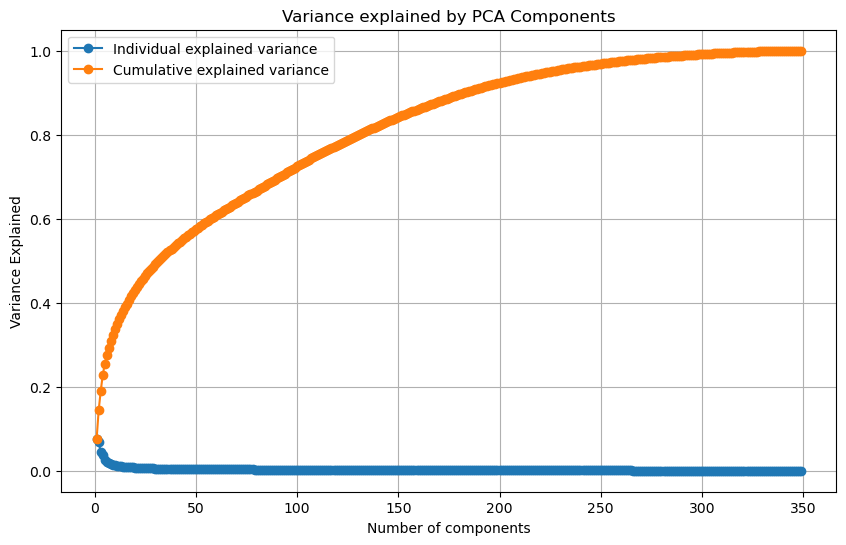

In [ ]:
# investigate the variance accounted for by each principal component
variance_explained = pca.explained_variance_ratio_
variance_cumulative = variance_explained.cumsum()

plt.figure(figsize=(10,6))
plt.plot(range(1, len(variance_explained) +  1), variance_explained, marker ='o', label='Individual explained variance')
plt.plot(range(1, len(variance_cumulative) + 1), variance_cumulative, marker='o', label='Cumulative explained variance')
plt.xlabel('Number of components')
plt.ylabel('Variance Explained')
plt.title('Variance explained by PCA Components')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# re-apply PCA to the data while selecting for number of components to retain
n_components = (variance_cumulative < 0.90).sum() + 1
print(f'Number of components to retain 90% variance: {n_components}')

pca2 = PCA(n_components)
azdias_pca2 = pca2.fit_transform(azdias_scaled)

print(f'Shape of the reduced dataset: {azdias_pca2.shape}')

Number of components to retain 90% variance: 183
Shape of the reduced dataset: (891221, 183)


The initial analysis of the variance suggests that a large number of components is required in order to capture the majority of the variance. <br>
The plot above shows that the first 90% of the variance is captured by approximately 160-200 components (further analysis revealed the number of 183). The remaining 10% is spread across nearly 47% of the components. Including these components into further analysis would unnecessary complicate the dataset without providing significant additional information. Therefore I decided to retain only 183 components. 

#### 1.8 Interpret Principal Components
Now that the principal components are transformed, I'll examine the weight of each variable on the first few components in order to determine if they have any interpretable patterns.

In [ ]:
# map weights for the first principal component to corresponding feature names
feature_names= azdias_scaled.columns

def sorted_feature_weights(pca2, component_num, feature_names, top_n=10):
    """
    Print the sorted list of feature weights for a specified principal component.

    This function maps the feature weights of a given principal component to corresponding feature names, sorts them by weight and prints\
    the top positive and negative weights for easier interpretation of component influence.

    Parameters:
    pca2 (PCA object): containig the fitted principal components.
    component_num (int): the index of the principal component to examone (0-indexed)
    feature_names: the names of the features used in the PCA transformation
    top_n (int): the number of top positive and negative weights to display for the specified principal component

    Returns:
    The top positive and negative features with their weights for the selected principal component.
    """
    component_weights = pca2.components_[component_num]
    component_df = pd.DataFrame({'feature': feature_names, 'weight': component_weights})
    component_df = component_df.sort_values(by='weight', ascending=False)
    print(f'Principal Component {component_num + 1}:')
    print(f'\nTop {top_n} positive features:')
    print(component_df.head(top_n).to_string(index=False))
    print(f'\nTop {top_n} negative features:')
    print(component_df.tail(top_n).to_string(index=False))

sorted_feature_weights(pca2, component_num=0, feature_names=feature_names)

Principal Component 1:

Top 10 positive features:
       feature   weight
    KBA05_SEG6 0.186118
  KBA05_KRSVAN 0.167210
 KBA05_KRSOBER 0.167086
  KBA05_KRSZUL 0.161390
KBA05_KRSKLEIN 0.158373
    KBA05_SEG8 0.155007
    KBA05_SEG7 0.150957
    KBA05_SEG9 0.150800
    KBA05_SEG1 0.147192
    KBA05_MOD8 0.147167

Top 10 negative features:
            feature    weight
    LP_FAMILIE_GROB -0.025040
LP_LEBENSPHASE_GROB -0.025243
 D19_VERSAND_ANZ_12 -0.025318
LP_LEBENSPHASE_FEIN -0.025861
         MOBI_REGIO -0.026129
          KBA05_GBZ -0.027136
 D19_VERSAND_ANZ_24 -0.028190
  D19_GESAMT_ANZ_12 -0.028654
  D19_GESAMT_ANZ_24 -0.031485
  ONLINE_AFFINITAET -0.034307


In [ ]:
# map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight

sorted_feature_weights(pca2, component_num=1, feature_names=feature_names)

Principal Component 2:

Top 10 positive features:
            feature   weight
         MOBI_REGIO 0.139500
         PLZ8_ANTG1 0.134046
     LP_STATUS_FEIN 0.132810
     LP_STATUS_GROB 0.132369
        KBA05_ANTG1 0.131377
  D19_GESAMT_ANZ_24 0.122252
          KBA05_GBZ 0.122087
LP_LEBENSPHASE_FEIN 0.120927
    KBA13_AUTOQUOTE 0.120620
  D19_GESAMT_ANZ_12 0.114179

Top 10 negative features:
                 feature    weight
D19_VERSAND_ONLINE_DATUM -0.110171
 D19_GESAMT_ONLINE_DATUM -0.113835
       D19_KONSUMTYP_MAX -0.115669
       D19_VERSAND_DATUM -0.117001
        D19_GESAMT_DATUM -0.121571
             PLZ8_BAUMAX -0.124558
              PLZ8_ANTG4 -0.126308
         CAMEO_INTL_2015 -0.132174
              PLZ8_ANTG3 -0.132248
         CAMEO_DEUG_2015 -0.134728


In [ ]:
# map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight

sorted_feature_weights(pca2, component_num=2, feature_names=feature_names)

Principal Component 3:

Top 10 positive features:
                feature   weight
          KBA13_SITZE_5 0.153780
   KBA13_SEG_KLEINWAGEN 0.139752
      KBA13_KMH_140_210 0.137282
        KBA13_HALTER_25 0.128680
          KBA13_KMH_180 0.128402
KBA13_SEG_KOMPAKTKLASSE 0.125224
          KBA13_KW_0_60 0.119166
      KBA13_HERST_ASIEN 0.114185
      KBA13_SEG_KLEINST 0.109370
   KBA13_ALTERHALTER_30 0.106714

Top 10 negative features:
                    feature    weight
             KBA13_CCM_2501 -0.128897
               KBA13_KW_121 -0.133297
              KBA13_KMH_250 -0.134945
              KBA13_KMH_211 -0.137173
       KBA13_SEG_SPORTWAGEN -0.142299
              KBA13_SITZE_4 -0.144067
                  KBA13_BMW -0.152875
KBA13_SEG_OBEREMITTELKLASSE -0.158294
             KBA13_MERCEDES -0.161532
       KBA13_HERST_BMW_BENZ -0.186309


The positive values of the first principal component are dominated by features related to specific car segments and ownership types such as KBA05_SEG6, KBA05_KRSVAN (share of vans (referred to the county average)), KBA05_KRSOBER (share of upper class cars (referred to the county average)) and KBA05_KRSZUL (share of newbuilt cars (referred to the county average)). Other significant features include various car model segments, indicating a focus on automotive attributes within the region.<br>
The negative values are associated with features such as LP_FAMILIE_GROB (familytyp rough),  (lifestage rough) and D19_VERSAND_ANZ_12 (transaction activity MAIL-ORDER in the last 12 months) along with indicators of online purchasing activity (ONLINE_AFFINITAET).<br>
This suggests that PC1 captures a contrast between areas charakterized by high levels of car ownership and specific vehicle preferences vs. regions where family life stage and online behaviors are more prevalent.

The positive values of the second principal component are dominated by features such as MOBI_REGIO, PLZ8_ANTG1 (number of 1-2 family houses in the PLZ8), LP_STATUS_FEIN und LP_STATUS_GROB (both representing social status categories) and KBA05_ANTG1 (number of 1-2 family houses in the cell). Other influential features include D19_GESAMT_ANZ_24 (transaction activity TOTAL POOL in the last 24 months) and LP_LEBENSPHASE_FEIN (lifestage fine).<br>
The negative values consist of features like D19_VERSAND_ONLINE_DATUM, D19_GESAMT_ONLINE_DATUM (actuality of the last transaction with the complete file ONLINE), PLZ8_BAUMAX (most common building-type within the PLZ8) and CAMEO_INTL_2015 (wealth classification).<br>
This suggests that PC2 captures a contrast between areas characterized by high car ownership, specific social status segments and family housing vs. regions with higher transaction volumes, online activity and urban building types.<br>

The positive values of the third principal component are dominated by features associated with smaller, compact or fuel-efficient cars such as KBA13_SITZE_5 (number of cars with 5 seats in the PLZ8), KBA13_SEG_KLEINWAGEN (share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8), KBA13_KMH_140_210 (share of cars with max speed between 140 and 210 km/h within the PLZ8). Other significant features include vehicles from Asian manufacturers KBA13_HERST_ASIEN (share of Asian Manufacturers within the PLZ8) and cars with lower engine power KBA13_KW_0_60 (share of cars up to 60 KW engine power - PLZ8), indicating a preference for economical, practical vehicles.<br>
The negative values include features associated with luxury and high-performance cars, such as KBA13_HERST_BMW_BENZ (share of BMW & Mercedes Benz within the PLZ8), KBA13_MERCEDES (share of MERCEDES within the PLZ8), KBA13_SEG_SPORTWAGEN (share of sportscars within the PLZ8) along with higher engine power and speed capabilities KBA13_KW_121 (share of cars with an engine power more than 120 KW - PLZ8) or KBA13_KMH_250 (share of cars with max speed between 210 and 250 km/h within the PLZ8).<br>
This suggests that PC3 captures a contrast between areas where residents prefer compact, economic vehicles and regions with a higher prevalence of luxury or performance cars.

## Part 2: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### 2.1 Apply Clustering to General Population
In this part I will examine how the data clusters in the principal components space. I will apply k-means clustering to the dataset and use the average within cluster distances for each point to their assigned cluster's centroid to decide on a number of clusters to keep.

In [ ]:
# run k-means clustering on the data over a number of different cluster counts and compute the average within-cluster distances
cluster_counts = range(2,20)
average_distances = []

for k in cluster_counts:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(azdias_pca2)

    average_distances.append(-kmeans.score(azdias_pca2) / len(azdias_pca2)) 

python(45759) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


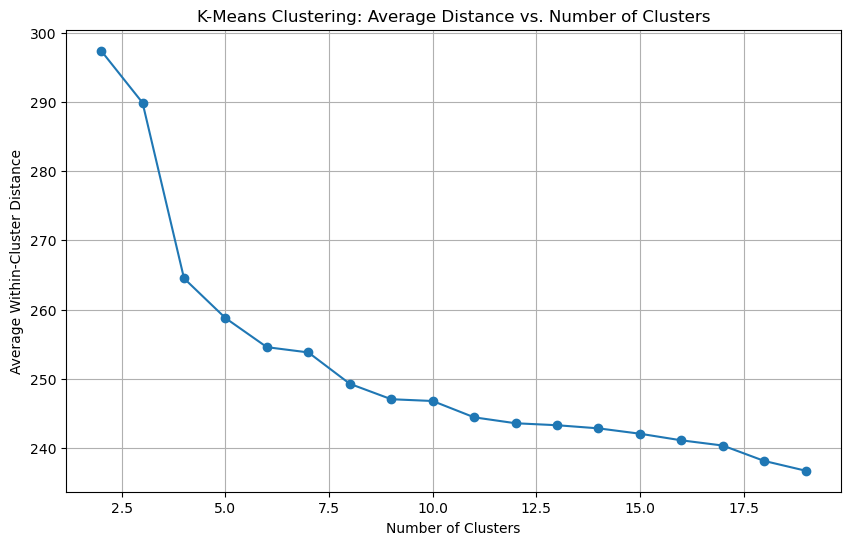

In [ ]:
# investigate the change in within-cluster distance across number of clusters
plt.figure(figsize=(10,6))
plt.plot(cluster_counts, average_distances, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Within-Cluster Distance')
plt.title('K-Means Clustering: Average Distance vs. Number of Clusters')
plt.grid(True)
plt.show()

In [ ]:
# fit the k-means model with the chosen cluster count and predict clusters for the general population demographics data
optimal_clusters = 8

final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
azdias_clusters = final_kmeans.fit_predict(azdias_pca2)

print(f'Cluster Assignment for the General Population Data: {np.unique(azdias_clusters)}')

Cluster Assignment for the General Population Data: [0 1 2 3 4 5 6 7]


I used the elbow method in order to examine the relationship between the number of clusters and the average within-cluster distance. The plot above revealed that the rate of decrease starts to slow down around the 8th cluster. Based on this analysis I decided to segment the general population into 8 clusters.

#### 2.2 Apply All Steps to the Customer Data

In [ ]:
# apply preprocessing, feature transformation, and clustering from the general demographics onto the customer data, obtaining cluster predictions for the 
# customer demographics data

# cleaning already done in the steps 1.1-1.4

customers_imputed = pd.DataFrame(imputer.transform(customers_cleaned3), columns=customers_cleaned3.columns)

customers_scaled = scaler.transform(customers_imputed)

customers_scaled2 = pd.DataFrame(customers_scaled, columns=customers_imputed.columns)
customers_scaled2 = customers_scaled2[azdias_scaled.columns]

customers_pca = pca2.transform(customers_scaled2)

customer_clusters = final_kmeans.predict(customers_pca)

print(f'Cluster Assignment for the Customer Population Data: {np.unique(customer_clusters)}')

Cluster Assignment for the Customer Population Data: [0 1 2 3 4 5 6 7]


#### 2.3 Compare Customer Data to Demographics Data

I have clustered the general population of Germany by demographics and mapped the mail-order company's customer data onto these clusters. Now I'll compare the cluster distributions to identify where the company's strongest customer base lies.


Overrepresented Clusters: 
    Cluster  General Population  Customers  Difference
0        0            0.179978   0.250157    0.070179
1        1            0.202504   0.252291    0.049786
2        2            0.111664   0.163953    0.052290
3        3            0.182460   0.233454    0.050995
5        5            0.002019   0.002452    0.000434
Underrepresented Clusters: 
    Cluster  General Population  Customers  Difference
4        4            0.107154   0.025499   -0.081655
6        6            0.197631   0.067325   -0.130306
7        7            0.016591   0.004868   -0.011723


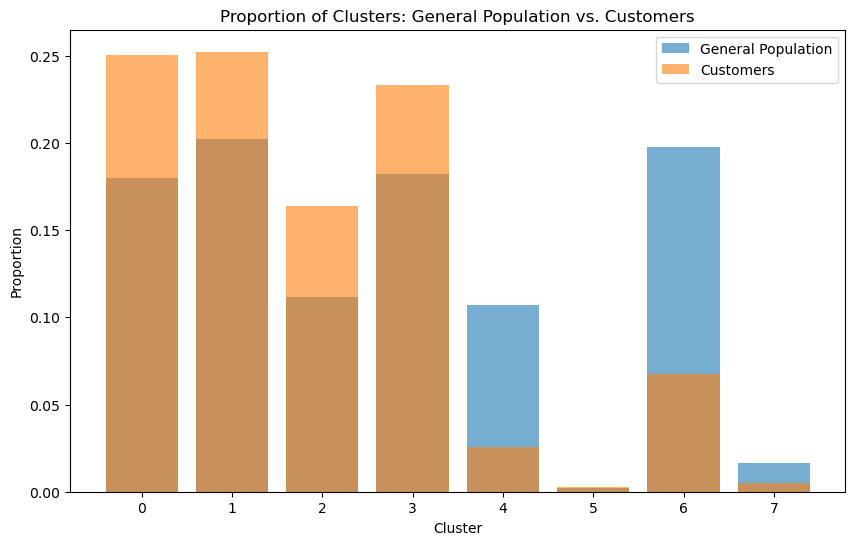

In [ ]:
# compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the general population
azdias_clusters, azdias_clusters_counts = np.unique(azdias_clusters, return_counts=True)
azdias_clusters_proportions = azdias_clusters_counts / azdias_clusters_counts.sum()

customer_clusters, customer_counts = np.unique(customer_clusters, return_counts=True)
customer_proportions = customer_counts / customer_counts.sum()

max_clusters = max(len(azdias_clusters_proportions), len(customer_proportions))
cluster_labels = np.arange(max_clusters)

cluster_proportions = pd.DataFrame({
    'Cluster': cluster_labels,
    'General Population': np.zeros(max_clusters),
    'Customers': np.zeros(max_clusters)
})

cluster_proportions.loc[:len(azdias_clusters_proportions) - 1, 'General Population'] = azdias_clusters_proportions
cluster_proportions.loc[:len(customer_proportions) - 1, 'Customers'] = customer_proportions

cluster_proportions['Difference'] = cluster_proportions['Customers'] - cluster_proportions['General Population']

overrepresented_clusters = cluster_proportions[cluster_proportions['Difference'] > 0]
print('Overrepresented Clusters: \n', overrepresented_clusters)

underrepresented_clusters = cluster_proportions[cluster_proportions['Difference'] < 0]
print('Underrepresented Clusters: \n', underrepresented_clusters)

plt.figure(figsize=(10,6))
plt.bar(range(len(azdias_clusters_proportions)), azdias_clusters_proportions, alpha=0.6, label='General Population')
plt.bar(range(len(customer_proportions)), customer_proportions, alpha=0.6, label='Customers')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend()
plt.title('Proportion of Clusters: General Population vs. Customers')
plt.show()

In [ ]:
# what kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?
cluster_0_centroid = final_kmeans.cluster_centers_[0]
cluster_0_centroid_reshaped = cluster_0_centroid.reshape(1,-1)
cluster_0_original_space = pca2.inverse_transform(cluster_0_centroid_reshaped)
cluster_0_features = scaler.inverse_transform(cluster_0_original_space)
cluster_0_df = pd.DataFrame(cluster_0_features, columns=customers_imputed.columns)
print(cluster_0_df)

   ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL    ARBEIT  \
0             7.743269      0.028872      1.495383   0.002917  3.085414   

   BALLRAUM  CAMEO_DEUG_2015  CAMEO_INTL_2015  CJT_GESAMTTYP  \
0  4.345191         5.573312        35.795982       4.506158   

   D19_BANKEN_ANZ_12  ...  CAMEO_DEU_2015_8A  CAMEO_DEU_2015_8B  \
0           0.005473  ...           0.027875           0.020488   

   CAMEO_DEU_2015_8C  CAMEO_DEU_2015_8D  CAMEO_DEU_2015_9A  CAMEO_DEU_2015_9B  \
0           0.017896           0.005768            0.01576           0.009039   

   CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  CAMEO_DEU_2015_9E  \
0           0.006505           0.009841           0.001417   

   CAMEO_DEU_2015_Unknown  
0                0.519022  

[1 rows x 349 columns]


In [ ]:
# what kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?
cluster_0_centroid = final_kmeans.cluster_centers_[6]
cluster_0_centroid_reshaped = cluster_0_centroid.reshape(1,-1)
cluster_0_original_space = pca2.inverse_transform(cluster_0_centroid_reshaped)
cluster_0_features = scaler.inverse_transform(cluster_0_original_space)
cluster_0_df = pd.DataFrame(cluster_0_features, columns=customers_imputed.columns)
print(cluster_0_df)

   ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL    ARBEIT  \
0            16.619794      0.066167      1.370808   0.002229  3.689852   

   BALLRAUM  CAMEO_DEUG_2015  CAMEO_INTL_2015  CJT_GESAMTTYP  \
0   2.77709         7.889015        47.836152       3.615326   

   D19_BANKEN_ANZ_12  ...  CAMEO_DEU_2015_8A  CAMEO_DEU_2015_8B  \
0           0.071877  ...           0.183628           0.077938   

   CAMEO_DEU_2015_8C  CAMEO_DEU_2015_8D  CAMEO_DEU_2015_9A  CAMEO_DEU_2015_9B  \
0           0.062593           0.031156           0.064426           0.082311   

   CAMEO_DEU_2015_9C  CAMEO_DEU_2015_9D  CAMEO_DEU_2015_9E  \
0           0.103434           0.119857           0.010255   

   CAMEO_DEU_2015_Unknown  
0                0.009423  

[1 rows x 349 columns]



The plot above shows that clusters 0, 1, 2, 3 and 5 have a significantly higher proportion of customers compared to general population, indicating that these clusters represent key target segments for the company.<br>

I analyzed individuals in the overrepresnted Cluster 0. According to their attributes these individuals are likely to reside in regions with around 7-8 active households (ANZ_HAUSHALTE_AKTIV 7.74) and have an average household size of about 1.5 people (ANZ_PERSONEN 1.5). They also appear to be in the age range associated with CAMEO categories that indicate comfortable, middle-income households with some wealth accumulation (CAMEO_INTL_2015 35.8). They score high in general activity and purchasing power (CJT_GESAMTTYP 4.5) with minimal recent banking transactions (D19_BANKEN_ANZ_12 0.005), suggesting financial stability. These individuals are likely financially secure, family-oriented and have moderate to high social engagement (BALLRAUM 4.3), making them an ideal target demographic.<br>

In contrast, clusters 4,6 and 7 are more prevalent in the general population than in the customer base, indicating these groups are less engaged with company's products. I analyzed individuals in the underrepresented Cluster 6. These individuals tend to live in areas with a higher number of active households (ANZ_HAUSHALTE_AKTIV 16.6). The CAMEO classification suggests they belong to less affluent households, possibly young couples with children (CAMEO_INTL_2015 47.8). They exhibit low interest in financial products (D19_BANKEN_ANZ_12 0.07) and their demographic profile aligns with orientation-seeking lower-income earners who man be budget-conscious.<br>

The analysis suggests that the company's marketing strategies might be more effective if focused on overrepresented clusters like Cluster 0, as these individuals are more likely to engage with the company's products.

## Part 3: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

#### 3.1 Build and Train The Model

In [341]:
# the datasets were loaded and cleaned in the step 1.5 (cleaned_train and cleaned_test)

# step 1:  split data into features and target
X_train = mailout_train.drop(columns=['RESPONSE'])
y_train = mailout_train['RESPONSE']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# initialize imputer and scaler and apply them to training and validation data
imputer_train = SimpleImputer(strategy='mean')
scaler_train = StandardScaler()

# step 2: impute missing values and then scale the data
X_train_imputed = pd.DataFrame(imputer_train.fit_transform(X_train), columns=X_train.columns)
X_val_imputed = pd.DataFrame(imputer_train.transform(X_val), columns=X_val.columns)

X_train_scaled = pd.DataFrame(scaler_train.fit_transform(X_train_imputed), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler_train.transform(X_val_imputed), columns=X_val.columns)

In [342]:
# step 3: apply clustering and add cluster label as a feature
X_train_pca = pd.DataFrame(pca2.transform(X_train_scaled))
X_val_pca = pd.DataFrame(pca2.transform(X_val_scaled))

X_train_pca['Cluster_Label'] = final_kmeans.predict(X_train_pca)
X_val_pca['Cluster_Label'] = final_kmeans.predict(X_val_pca)

In [345]:
X_train_pca.columns = X_train_pca.columns.astype(str)
X_val_pca.columns = X_val_pca.columns.astype(str)

# step 4: initialize and train logistic regression
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0)
model.fit(X_train_pca, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0)

In [346]:
# step 5: predict and evaluate on validation set
y_val_pred = model.predict(X_val_pca)
print(classification_report(y_val, y_val_pred, target_names=['Non-customer', 'Customer']))

              precision    recall  f1-score   support

Non-customer       0.99      0.69      0.81      8489
    Customer       0.01      0.38      0.03       104

    accuracy                           0.69      8593
   macro avg       0.50      0.53      0.42      8593
weighted avg       0.98      0.69      0.80      8593



The model performs very well in ifentifying 'Non-Customers' with high precision (0.99), recall (0.69) and F1-score (0.81). However, it struggles significantly with the 'Customer' class, showing low precision (0.01) and F1-score of 0.03, despite achieveing a recall of 0.38 for this minority class. This indicates that the model is better at predicting the majority class, but it lacks accuracy in identifying actual customers due to the dataset's imbalance.<br>

In [352]:
# apply GridSearchCV to optimize the model
# define the parameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [1000]
}

# initialize the model and GridSearchCV
logistic_regression = LogisticRegression(class_weight='balanced', random_state=0)
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

# fit gridsearch CV
grid_search.fit(X_train_pca, y_train)

# get the best model from GridSearchCV
optimized_model = grid_search.best_estimator_

# evaluate the optimized model on the validation set
y_val_pred_optimized = optimized_model.predict(X_val_pca)
print(grid_search.best_params_)
print(classification_report(y_val, y_val_pred_optimized, target_names=['Non-customer', 'Customer']))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


python(54056) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54058) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54059) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54060) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54061) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54062) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/li

{'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

Non-customer       0.99      0.69      0.81      8489
    Customer       0.01      0.38      0.03       104

    accuracy                           0.69      8593
   macro avg       0.50      0.53      0.42      8593
weighted avg       0.98      0.69      0.80      8593



The application of GridSearchCV resulted in a model with the same performance as the initial approach, indicating that the parameter tuning did not significantly improve the model's predicting power. In the next step, predictions are created based on the initial model.<br>
If time permitted, futher steps could include exploring data balancing techniques, like oversampling, or experimenting with alternative models to enhance prediction accuracy, particularly for the 'Customer' class.

#### 3.2 Create Predictions

In [347]:
# step 1: load preprocessed mailout_test
X_test = mailout_test

# step 2: initialize imputer and scaler
imputer_test = SimpleImputer(strategy='mean')
scaler_test = StandardScaler()

# step 3: Impute missing values and scale the data
X_test_imputed = pd.DataFrame(imputer_test.fit_transform(X_test), columns=X_test.columns)
X_test_scaled = pd.DataFrame(scaler_test.fit_transform(X_test_imputed), columns=X_test.columns)

# step 4: Apply PCA to reduce dimensionality
X_test_pca = pd.DataFrame(pca2.transform(X_test_scaled))

# step 5: predict clusters and add as a feature
X_test_pca['Cluster_Label'] = final_kmeans.predict(X_test_pca)


In [348]:
# ensure all column names are strings in X_test_pca to avoid type mismath issues
X_test_pca.columns = X_test_pca.columns.astype(str)

# step 6: make predictions using trained model
y_test_pred = model.predict(X_test_pca)

In [350]:
# save predictions to a dataframe
test_predictions = pd.DataFrame({
    'ID': X_test.index,
    'Response_Prediction': y_test_pred
})

# Save predictions to a csv
test_predictions.to_csv('test_predictions.csv', index=False)
print("Predictions for test set have been saved to 'test_predictions.csv'.")

Predictions for test set have been saved to 'test_predictions.csv'.
